# SFCA and RAAM script tests at Middle Layer Super Output Areas (MSOA) level using OSRM distance (30 miles threshold/exclude London)

In [2]:
from access import access, weights, datasets
import logging
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import mapclassify as mc
from legendgram import legendgram
import palettable.matplotlib as palmpl
import seaborn as sns
import numpy as np
from scipy import stats

In [2]:
#pip install cartopy

# Data import

## Get LA——MSOA code data

In [44]:
LA_MSOA = pd.read_csv('https://raw.githubusercontent.com/LingruFeng/dissertation/main/data_raw/LA_MSOA_code.csv')
LA_MSOA

LA_Code_2020 LA_name_2020  MSOA Code
0       E06000001   Hartlepool  E02002483
1       E06000001   Hartlepool  E02002484
2       E06000001   Hartlepool  E02002485
3       E06000001   Hartlepool  E02002487
4       E06000001   Hartlepool  E02002488
...           ...          ...        ...
6786    E09000033  Westminster  E02000979
6787    E09000033  Westminster  E02000980
6788    E09000033  Westminster  E02000981
6789    E09000033  Westminster  E02000982
6790    E09000033  Westminster  E02000983

[6791 rows x 3 columns]

## Get MSOA boundary data

In [45]:
MSOA=gpd.read_file('https://github.com/LingruFeng/dissertation/blob/main/data_github/England_basemap/MSOA_Boundary_with_population.gpkg?raw=true')
MSOA = MSOA.to_crs('epsg:27700')

## Get the population weighted centroid of MSOA (demand points)

In [46]:
MSOA_points=gpd.read_file('https://github.com/LingruFeng/dissertation/blob/main/data_github/England_basemap/MSOA_Population_Weighted_Centroids_with_population.gpkg?raw=true')
MSOA_points = MSOA_points.to_crs('epsg:27700')

### Calculate population over 60

In [47]:
MSOA_points['pop60+69'] = MSOA_points['pop60-69']

In [48]:
MSOA_points

objectid   msoa11cd  pop0-49  pop50-59  pop60-69  pop70-79  pop80-89  \
0            1  E02002536     5688      1416      1132       891       540   
1            2  E02002537     5578      1251       836       545       386   
2            3  E02002534     2547       824       863       967       407   
3            4  E02002535     4959      1636      1385       870       416   
4            5  E02002532     3783       970       810       655       342   
...        ...        ...      ...       ...       ...       ...       ...   
6786      6787  E02004669     3697      1171      1156       946       433   
6787      6788  E02006096     3893      1086       805       804       344   
6788      6789  E02003088     4007      1257      1230      1194       577   
6789      6790  E02006070     5161      1163       906       670       316   
6790      6791  E02006679     6429      1744      1408      1177       560   

      pop90+  total_pop                       geometry  pop60+69  
0        104       9771  POINT (445582.345 524175.434)      1132  
1         45       8641  POINT (446777.151 524256.841)       836  
2         85       5693  POINT (461356.929 515118.900)       863  
3         70       9336  POINT (446117.027 525455.836)      1385  
4         95       6655  POINT (461053.212 516175.379)       810  
...      ...        ...                            ...       ...  
6786      93       7496  POINT (393469.114 227500.260)      1156  
6787      69       7001  POINT (332829.367 109219.836)       805  
6788     179       8444  POINT (343276.340 158947.520)      1230  
6789      75       8291  POINT (331710.269 136880.200)       906  
6790      96      11414  POINT (390561.555 162786.953)      1408  

[6791 rows x 11 columns]

## read vaccination site point data (supply points)

In [49]:
site = gpd.read_file('https://github.com/LingruFeng/dissertation/blob/main/data_github/site_2_26_clean/vaccination_site.gpkg?raw=true')
site = site.to_crs('epsg:27700')

# Read in the driving distance from the point of demand to the point of supply as cost (Generated by driving_cost_calculation_OSRM.ipynb in data_raw folder)

In [50]:
distance_cost_df = pd.read_csv('distance_cost_final_OSRM.csv') 
distance_cost_df = distance_cost_df.rename(columns={"Distance in meter": "cost", "origin_id": "origin", "destination_id": "dest"})
distance_cost_df

cost     origin  dest
0         6712.7  E02002536   122
1        56619.8  E02002536   123
2        51152.7  E02002536   126
3        13881.2  E02002536   127
4        50625.1  E02002536   128
...          ...        ...   ...
1674418  48512.4  E02006679  1458
1674419  43150.5  E02006679  1460
1674420  26966.3  E02006679  1591
1674421  49329.1  E02006679  1592
1674422  60462.9  E02006679  1593

[1674423 rows x 3 columns]

# Calculate the MSOAs that have no vaccination service within 10 miles distance and plot the map

In [51]:
# Get demand MSOAs that have at least one vaccination site within 10 miles of distance
distance_cost_df_test = distance_cost_df.loc[distance_cost_df['cost']<16093.44]
distance_cost_df_test

a = pd.unique(distance_cost_df_test['origin'])

# Set 'MSOA_with_supply' field True if a place has at least one vaccination site within 10 miles of distance, otherwise False.
b = pd.DataFrame()
b['MSOA'] = a
b['MSOA_with_supply'] = True

MSOA_with_supply = pd.merge(left = MSOA,right = b, how='left', left_on='MSOA11CD', right_on='MSOA')
MSOA_with_supply=MSOA_with_supply.fillna(False)

### Count the number of MSOAs that are lack of vaccination service

In [52]:
m = MSOA_with_supply[MSOA_with_supply['MSOA_with_supply']==False]
print('There are',m['MSOA11CD'].count(),'MSOAs that are lack of vaccination service setting 10 miles as the vaccination service radius threshold.')

There are 383 MSOAs that are lack of vaccination service setting 10 miles as the vaccination service radius threshold.


### Plot the regions that are lack of service

In [53]:
# Get the boundary of England
MSOA_with_supply['dissolve']=1
MSOA_outline = MSOA_with_supply.dissolve(by='dissolve')

In [54]:
# Plot the map
f,ax = plt.subplots(figsize=(10,10))
m.plot(figsize = (10,10),ax=ax)
MSOA_outline.plot(edgecolor=(0.8, 0, 0,0.8), facecolor='none', linewidth=1,ax=ax)
ax.axis('off')
ax.set_title('MSOAs Lack of Vaccination Service', fontdict={'fontsize':'20', 'fontweight':'3'})

Text(0.5, 1.0, 'MSOAs Lack of Vaccination Service')

# Create a dataframe for the accessibility calculation using the Driving distance from the point of demand to the point of supply as cost

In [30]:
fca = access(demand_df = MSOA_points,
           demand_index='msoa11cd',
           demand_value='pop60+69',
           supply_df= site,
           supply_index= 'index',
           supply_value=['supply_value'],
           cost_df              = distance_cost_df,
           cost_origin          = 'origin',
           cost_dest            = 'dest',
           cost_name            = 'cost',
           neighbor_cost_df     = distance_cost_df,
           neighbor_cost_origin = 'origin',
           neighbor_cost_dest   = 'dest',
           neighbor_cost_name   = 'cost')

### 2SFCA

In [31]:
# Using 2SFCA method, 16093.44 meters (10 miles) is used as service threshold radius to calculate the accessibility
fca.two_stage_fca(name = "2sfca_10",max_cost = 16093.44)
fca.two_stage_fca(name = "2sfca_15",max_cost = 24140.16)
fca.two_stage_fca(name = "2sfca_20",max_cost = 32186.88)
fca.two_stage_fca(name = "2sfca_25",max_cost = 40233.60)
fca.two_stage_fca(name = "2sfca_30",max_cost = 48280.32)

2sfca_30_supply_value
msoa11cd                        
E02000001               0.001005
E02000002               0.001001
E02000003               0.000997
E02000004               0.000955
E02000005               0.000980
...                          ...
E02006930               0.000971
E02006931               0.000999
E02006932               0.000135
E02006933               0.000132
E02006934               0.000135

[6791 rows x 1 columns]

### E2SFCA

#### Set distance decay weight using gaussian function.

In [32]:
# Define a gaussian weight. Here, set the σ to be 5364.48 (meters), which is one third of the threshold, such that we'll be at the 3σ level at 16093.44 meters.
# 用3σ原理解释参数的选择 (According to the the empirical rule, also referred to as the three-sigma rule,
# for a normal distribution, almost all observed data will fall within three standard deviations.因此当距离接近threshold时，weight趋近于0)
gaussian_10 = weights.gaussian(sigma =5364.48)
gaussian_15 = weights.gaussian(sigma =8064.72)
gaussian_20 = weights.gaussian(sigma =10728.96)
gaussian_25 = weights.gaussian(sigma =13411.20)
gaussian_30 = weights.gaussian(sigma =16093.44)

fca.enhanced_two_stage_fca(name = "E2sfca_10", weight_fn = gaussian_10)
fca.enhanced_two_stage_fca(name = "E2sfca_15", weight_fn = gaussian_15)
fca.enhanced_two_stage_fca(name = "E2sfca_20", weight_fn = gaussian_20)
fca.enhanced_two_stage_fca(name = "E2sfca_25", weight_fn = gaussian_25)
fca.enhanced_two_stage_fca(name = "E2sfca_30", weight_fn = gaussian_30)

E2sfca_30_supply_value
msoa11cd                         
E02000001                0.001665
E02000002                0.000698
E02000003                0.000726
E02000004                0.000612
E02000005                0.000752
...                           ...
E02006930                0.001331
E02006931                0.001405
E02006932                0.000176
E02006933                0.000158
E02006934                0.000167

[6791 rows x 1 columns]

### 3SFCA

In [33]:
fca.three_stage_fca(name = "3sfca_10", weight_fn = gaussian_10)

3sfca_10_supply_value
msoa11cd                        
E02000001               0.002644
E02000002               0.000402
E02000003               0.000446
E02000004               0.000308
E02000005               0.000449
...                          ...
E02006930               0.001224
E02006931               0.001311
E02006932               0.000101
E02006933               0.000074
E02006934               0.000102

[6791 rows x 1 columns]

In [34]:
fca.three_stage_fca(name = "3sfca_15", weight_fn = gaussian_15)

3sfca_15_supply_value
msoa11cd                        
E02000001               0.002012
E02000002               0.000574
E02000003               0.000608
E02000004               0.000486
E02000005               0.000626
...                          ...
E02006930               0.001305
E02006931               0.001372
E02006932               0.000104
E02006933               0.000089
E02006934               0.000100

[6791 rows x 1 columns]

In [35]:
fca.three_stage_fca(name = "3sfca_20", weight_fn = gaussian_20)

3sfca_20_supply_value
msoa11cd                        
E02000001               0.001673
E02000002               0.000687
E02000003               0.000702
E02000004               0.000583
E02000005               0.000706
...                          ...
E02006930               0.001275
E02006931               0.001331
E02006932               0.000117
E02006933               0.000105
E02006934               0.000108

[6791 rows x 1 columns]

In [36]:
fca.three_stage_fca(name = "3sfca_25", weight_fn = gaussian_25)

3sfca_25_supply_value
msoa11cd                        
E02000001               0.001484
E02000002               0.000734
E02000003               0.000747
E02000004               0.000633
E02000005               0.000752
...                          ...
E02006930               0.001234
E02006931               0.001274
E02006932               0.000125
E02006933               0.000116
E02006934               0.000116

[6791 rows x 1 columns]

In [37]:
fca.three_stage_fca(name = "3sfca_30", weight_fn = gaussian_30)

3sfca_30_supply_value
msoa11cd                        
E02000001               0.001366
E02000002               0.000757
E02000003               0.000772
E02000004               0.000672
E02000005               0.000782
...                          ...
E02006930               0.001187
E02006931               0.001217
E02006932               0.000133
E02006933               0.000125
E02006934               0.000126

[6791 rows x 1 columns]

## See the result

In [38]:
fca.access_df.head()

pop60+69  2sfca_10_supply_value  2sfca_15_supply_value  \
msoa11cd                                                            
E02000001      1025               0.002110               0.001588   
E02000002       505               0.000397               0.000585   
E02000003       886               0.000392               0.000680   
E02000004       598               0.000276               0.000495   
E02000005       629               0.000386               0.000709   

           2sfca_20_supply_value  2sfca_25_supply_value  \
msoa11cd                                                  
E02000001               0.001263               0.001109   
E02000002               0.000917               0.000997   
E02000003               0.000955               0.001000   
E02000004               0.000882               0.000988   
E02000005               0.000996               0.000992   

           2sfca_30_supply_value  E2sfca_10_supply_value  \
msoa11cd                                                   
E02000001               0.001005                0.003061   
E02000002               0.001001                0.000336   
E02000003               0.000997                0.000383   
E02000004               0.000955                0.000254   
E02000005               0.000980                0.000390   

           E2sfca_15_supply_value  E2sfca_20_supply_value  \
msoa11cd                                                    
E02000001                0.002470                0.002103   
E02000002                0.000399                0.000496   
E02000003                0.000429                0.000527   
E02000004                0.000298                0.000393   
E02000005                0.000442                0.000550   

           E2sfca_25_supply_value  E2sfca_30_supply_value  \
msoa11cd                                                    
E02000001                0.001849                0.001665   
E02000002                0.000605                0.000698   
E02000003                0.000636                0.000726   
E02000004                0.000508                0.000612   
E02000005                0.000663                0.000752   

           3sfca_10_supply_value  3sfca_15_supply_value  \
msoa11cd                                                  
E02000001               0.002644               0.002012   
E02000002               0.000402               0.000574   
E02000003               0.000446               0.000608   
E02000004               0.000308               0.000486   
E02000005               0.000449               0.000626   

           3sfca_20_supply_value  3sfca_25_supply_value  3sfca_30_supply_value  
msoa11cd                                                                        
E02000001               0.001673               0.001484               0.001366  
E02000002               0.000687               0.000734               0.000757  
E02000003               0.000702               0.000747               0.000772  
E02000004               0.000583               0.000633               0.000672  
E02000005               0.000706               0.000752               0.000782

# Show the accessibility/vaccination rate result on map

In [39]:
MSOA_fca = pd.merge(left=MSOA, right=fca.access_df, how='left', left_on='MSOA11CD', right_on='msoa11cd')
MSOA_fca=MSOA_fca.fillna(0)
MSOA_fca = MSOA_fca.rename(columns={"2sfca_10_supply_value": "2sfca_10", "2sfca_15_supply_value": "2sfca_15", 
                                    "2sfca_20_supply_value": "2sfca_20", "2sfca_25_supply_value": "2sfca_25","2sfca_30_supply_value": "2sfca_30",
                                   "E2sfca_10_supply_value": "E2sfca_10", "E2sfca_15_supply_value": "E2sfca_15", 
                                    "E2sfca_20_supply_value": "E2sfca_20", "E2sfca_25_supply_value": "E2sfca_25","E2sfca_30_supply_value": "E2sfca_30",
                                   "3sfca_10_supply_value": "3sfca_10", "3sfca_15_supply_value": "3sfca_15", 
                                    "3sfca_20_supply_value": "3sfca_20", "3sfca_25_supply_value": "3sfca_25","3sfca_30_supply_value": "3sfca_30"})

## Add vaccination population data and calculate vaccination rate

In [40]:
# Read the vaccination population data
url = 'https://raw.githubusercontent.com/LingruFeng/dissertation/main/data_raw/vaccination_number_2020_12_8_2021_3_7.csv'
vaccination_pop = pd.read_csv(url)

In [41]:
vaccination_pop['60-69'] = vaccination_pop['over60_64'] + vaccination_pop['over65_69']

# merge the population data
MSOA_fca = pd.merge(left = MSOA_fca, right=vaccination_pop, how='left', left_on='MSOA11CD', right_on='MSOA_code')

# merge the LA information
MSOA_fca = pd.merge(left = MSOA_fca, right=LA_MSOA, how='left', left_on='MSOA11CD', right_on='MSOA Code')

In [42]:
MSOA_fca['vaccination_percentage_for60+69'] = MSOA_fca['60-69']/MSOA_fca['pop60+69']

# Set vaccination rate greater than 1 to 1
MSOA_fca['vaccination_rate_60+69']= np.where(MSOA_fca['vaccination_percentage_for60+69']>1, 1, MSOA_fca['vaccination_percentage_for60+69'])

## Exclude London regions

In [55]:
# Get the London boundary map for more conplex map plot 
# Read some London Boundary data for map show
# An intricate map of London's borders
borough = gpd.read_file('https://github.com/LingruFeng/0006_DSSS_assessment/blob/main/London_Boroughs.gpkg?raw=true')
borough = borough.to_crs('epsg:27700')
London = pd.merge(left = MSOA_fca, right=borough[['gss_code','objectid']],how = 'left', left_on='LA_Code_2020', right_on='gss_code')
London = London.dropna()
London['London'] = 'London'
London_boundary = London.dissolve(by='London')

# A rough map of the borders of London
inner=gpd.read_file('https://github.com/LingruFeng/i2p_assessment3/blob/main/inner_outer.gpkg?raw=true')
inner = inner.to_crs('epsg:27700')
inner = inner.dissolve(by='Source')

In [58]:
London

Empty GeoDataFrame
Columns: [LA_Code_2020, LA_name_2020, MSOA11CD, MSOA11NM, pop60+69, 60-69, vaccination_rate_60+69, 2sfca_10_normalized, 2sfca_15_normalized, 2sfca_20_normalized, 2sfca_25_normalized, 2sfca_30_normalized, E2sfca_10_normalized, E2sfca_15_normalized, E2sfca_20_normalized, E2sfca_25_normalized, E2sfca_30_normalized, 3sfca_10_normalized, 3sfca_15_normalized, 3sfca_20_normalized, 3sfca_25_normalized, 3sfca_30_normalized, geometry, gss_code, objectid, London]
Index: []

[0 rows x 26 columns]

In [44]:
test = pd.merge(left = MSOA_fca, right=borough[['gss_code','objectid']],how = 'left', left_on='LA_Code_2020', right_on='gss_code')
MSOA_fca =test[pd.isnull(test).any(axis=1)]
MSOA_fca

MSOA11CD        MSOA11NM  pop0-49  pop50-59  pop60-69  pop70-79  \
951   E02000984      Bolton 001     4182      1239       913       844   
952   E02000985      Bolton 002     3577      1186       947       989   
953   E02000986      Bolton 003     5042      1272       897       781   
954   E02000987      Bolton 004     4120      1155       788       717   
955   E02000988      Bolton 005     6027      1095       832       590   
...         ...             ...      ...       ...       ...       ...   
6779  E02006922  Colchester 022     7959      1933      1609      1531   
6782  E02006926    Thurrock 020     6172      1138       545       287   
6788  E02006932   Liverpool 060    16963       264       173        80   
6789  E02006933   Liverpool 061     7130       603       485       220   
6790  E02006934   Liverpool 062     7653       372       216        98   

      pop80-89  pop90+  total_pop  \
951        289      43       7510   
952        485      71       7255   
953        418      96       8506   
954        340      85       7205   
955        289      65       8898   
...        ...     ...        ...   
6779       767     144      13943   
6782       102      13       8257   
6788        25      10      17515   
6789        97       4       8539   
6790        34       8       8381   

                                               geometry  ...  over75_79  \
951   POLYGON ((372121.741 414318.582, 372147.184 41...  ...        373   
952   POLYGON ((372971.325 411456.076, 373104.966 41...  ...        417   
953   POLYGON ((372147.184 413616.095, 372503.949 41...  ...        342   
954   POLYGON ((363078.556 411480.529, 363041.920 41...  ...        319   
955   POLYGON ((371044.136 412457.779, 371567.570 41...  ...        235   
...                                                 ...  ...        ...   
6779  MULTIPOLYGON (((601481.105 224815.326, 601485....  ...        689   
6782  POLYGON ((561100.600 178929.667, 560928.979 17...  ...        104   
6788  POLYGON ((335757.632 390987.474, 335739.219 39...  ...         39   
6789  POLYGON ((335096.788 389638.891, 334715.024 38...  ...         94   
6790  POLYGON ((334805.261 391362.101, 334590.333 39...  ...         26   

      over80  60-69  LA_Code_2020  LA_name_2020  MSOA Code  \
951      340    844     E08000001        Bolton  E02000984   
952      576    817     E08000001        Bolton  E02000985   
953      512    785     E08000001        Bolton  E02000986   
954      376    723     E08000001        Bolton  E02000987   
955      365    714     E08000001        Bolton  E02000988   
...      ...    ...           ...           ...        ...   
6779     898   1194     E07000071    Colchester  E02006922   
6782     116    388     E06000034      Thurrock  E02006926   
6788      33    137     E08000012     Liverpool  E02006932   
6789      82    376     E08000012     Liverpool  E02006933   
6790      26    162     E08000012     Liverpool  E02006934   

      vaccination_percentage_for60+69  vaccination_rate_60+69  gss_code  \
951                          0.924425                0.924425       NaN   
952                          0.862724                0.862724       NaN   
953                          0.875139                0.875139       NaN   
954                          0.917513                0.917513       NaN   
955                          0.858173                0.858173       NaN   
...                               ...                     ...       ...   
6779                         0.742076                0.742076       NaN   
6782                         0.711927                0.711927       NaN   
6788                         0.791908                0.791908       NaN   
6789                         0.775258                0.775258       NaN   
6790                         0.750000                0.750000       NaN   

      objectid  
951        NaN  
952        NaN  
953        NaN  
954        NaN  
955        NaN  
...        ...  
6779   

## Use min-max normalization to normalize the accessibility score

In [45]:
MSOA_fca['2sfca_10_normalized'] = (MSOA_fca['2sfca_10']-MSOA_fca['2sfca_10'].min())/(MSOA_fca['2sfca_10'].max()-MSOA_fca['2sfca_10'].min())
MSOA_fca['2sfca_15_normalized'] = (MSOA_fca['2sfca_15']-MSOA_fca['2sfca_15'].min())/(MSOA_fca['2sfca_15'].max()-MSOA_fca['2sfca_15'].min())
MSOA_fca['2sfca_20_normalized'] = (MSOA_fca['2sfca_20']-MSOA_fca['2sfca_20'].min())/(MSOA_fca['2sfca_20'].max()-MSOA_fca['2sfca_20'].min())
MSOA_fca['2sfca_25_normalized'] = (MSOA_fca['2sfca_25']-MSOA_fca['2sfca_25'].min())/(MSOA_fca['2sfca_25'].max()-MSOA_fca['2sfca_25'].min())
MSOA_fca['2sfca_30_normalized'] = (MSOA_fca['2sfca_30']-MSOA_fca['2sfca_30'].min())/(MSOA_fca['2sfca_30'].max()-MSOA_fca['2sfca_30'].min())


MSOA_fca['E2sfca_10_normalized'] = (MSOA_fca['E2sfca_10']-MSOA_fca['E2sfca_10'].min())/(MSOA_fca['E2sfca_10'].max()-MSOA_fca['E2sfca_10'].min())
MSOA_fca['E2sfca_15_normalized'] = (MSOA_fca['E2sfca_15']-MSOA_fca['E2sfca_15'].min())/(MSOA_fca['E2sfca_15'].max()-MSOA_fca['E2sfca_15'].min())
MSOA_fca['E2sfca_20_normalized'] = (MSOA_fca['E2sfca_20']-MSOA_fca['E2sfca_20'].min())/(MSOA_fca['E2sfca_20'].max()-MSOA_fca['E2sfca_20'].min())
MSOA_fca['E2sfca_25_normalized'] = (MSOA_fca['E2sfca_25']-MSOA_fca['E2sfca_25'].min())/(MSOA_fca['E2sfca_25'].max()-MSOA_fca['E2sfca_25'].min())
MSOA_fca['E2sfca_30_normalized'] = (MSOA_fca['E2sfca_30']-MSOA_fca['E2sfca_30'].min())/(MSOA_fca['E2sfca_30'].max()-MSOA_fca['E2sfca_30'].min())

MSOA_fca['3sfca_10_normalized'] = (MSOA_fca['3sfca_10']-MSOA_fca['3sfca_10'].min())/(MSOA_fca['3sfca_10'].max()-MSOA_fca['2sfca_10'].min())
MSOA_fca['3sfca_15_normalized'] = (MSOA_fca['3sfca_15']-MSOA_fca['3sfca_15'].min())/(MSOA_fca['3sfca_15'].max()-MSOA_fca['2sfca_15'].min())
MSOA_fca['3sfca_20_normalized'] = (MSOA_fca['3sfca_20']-MSOA_fca['3sfca_20'].min())/(MSOA_fca['3sfca_20'].max()-MSOA_fca['2sfca_20'].min())
MSOA_fca['3sfca_25_normalized'] = (MSOA_fca['3sfca_25']-MSOA_fca['3sfca_25'].min())/(MSOA_fca['3sfca_25'].max()-MSOA_fca['2sfca_25'].min())
MSOA_fca['3sfca_30_normalized'] = (MSOA_fca['3sfca_30']-MSOA_fca['3sfca_30'].min())/(MSOA_fca['3sfca_30'].max()-MSOA_fca['2sfca_30'].min())


#MSOA_fca['raam_normalized'] = (MSOA_fca['raam']-MSOA_fca['raam'].min())/(MSOA_fca['raam'].max()-MSOA_fca['raam'].min())
#MSOA_fca['raam_inverse_normalize'] = 1-MSOA_fca['raam_normalized']

/opt/conda/envs/sds2020/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [46]:
# Subset the columns to only needed ones
MSOA_fca = MSOA_fca[['LA_Code_2020','LA_name_2020','MSOA11CD','MSOA11NM','pop60+69','60-69',
                     'vaccination_rate_60+69',
                     '2sfca_10_normalized','2sfca_15_normalized','2sfca_20_normalized','2sfca_25_normalized','2sfca_30_normalized',
                     'E2sfca_10_normalized','E2sfca_15_normalized','E2sfca_20_normalized','E2sfca_25_normalized','E2sfca_30_normalized',
                     '3sfca_10_normalized','3sfca_15_normalized','3sfca_20_normalized','3sfca_25_normalized','3sfca_30_normalized',
                     'geometry']]

In [48]:
# Export result data
MSOA_fca.to_csv('fca_result_exclude_London.csv',index=False)
MSOA_fca.to_file("fca_result_exclude_London.gpkg", driver="GPKG")

# Read data for plotting (generated above)

In [7]:
MSOA_fca = gpd.read_file('fca_result_exclude_London.gpkg')
MSOA_fca = MSOA_fca.to_crs('epsg:27700')

In [8]:
MSOA_fca.shape

(5808, 23)

In [6]:
MSOA_fca.describe()

pop60+69        60-69  vaccination_rate_60+69  2sfca_10_normalized  \
count  5808.000000  5808.000000             5808.000000          5808.000000   
mean    896.104511   708.324897                0.789026             0.258172   
std     252.222748   215.686775                0.084755             0.154465   
min      90.000000    74.000000                0.161227             0.000000   
25%     722.000000   561.000000                0.735322             0.153905   
50%     865.000000   686.500000                0.791744             0.242007   
75%    1045.000000   834.000000                0.847990             0.340521   
max    2082.000000  1769.000000                1.000000             1.000000   

       2sfca_15_normalized  2sfca_20_normalized  2sfca_25_normalized  \
count          5808.000000          5808.000000          5808.000000   
mean              0.163950             0.152347             0.163136   
std               0.086610             0.100005             0.131329   
min               0.000000             0.000000             0.000000   
25%               0.111716             0.103527             0.107819   
50%               0.154471             0.140516             0.139131   
75%               0.201576             0.171226             0.168657   
max               1.000000             1.000000             1.000000   

       2sfca_30_normalized  E2sfca_10_normalized  E2sfca_15_normalized  \
count          5808.000000           5808.000000           5808.000000   
mean              0.185089              0.161541              0.259683   
std               0.162890              0.127783              0.155758   
min               0.000000              0.000000              0.000000   
25%               0.115700              0.068260              0.152133   
50%               0.147574              0.142569              0.241373   
75%               0.178447              0.228327              0.348066   
max               1.000000              1.000000              1.000000   

       E2sfca_20_normalized  E2sfca_25_normalized  E2sfca_30_normalized  \
count           5808.000000           5808.000000           5808.000000   
mean               0.232551              0.203162              0.186703   
std                0.121498              0.103098              0.098492   
min                0.000000              0.000000              0.000000   
25%                0.152602              0.138261              0.128354   
50%                0.219569              0.192452              0.176032   
75%                0.295774              0.247004              0.219949   
max                1.000000              1.000000              1.000000   

       3sfca_10_normalized  3sfca_15_normalized  3sfca_20_normalized  \
count          5808.000000          5808.000000          5808.000000   
mean              0.151299             0.203554             0.196895   
std               0.126821             0.141983             0.129091   
min               0.000000             0.000000             0.000000   
25%               0.062488             0.113079             0.120326   
50%               0.129876             0.178915             0.173482   
75%               0.208518             0.258539             0.234771   
max               1.000000             1.000000             1.000000   

       3sfca_25_normalized  3sfca_30_normalized  
count          5808.000000          5808.000000  
mean              0.193871             0.195803  
std               0.123430             0.123036  
min               0.000000             0.000000  
25%               0.124600             0.127917  
50%               0.169323             0.168078  
75%               0.220630             0.218584  
max               1.000000             1.000000

## Map plot code

In [9]:
# function for scale bar
import cartopy.crs as ccrs
import cartopy.geodesic as cgeo
def _axes_to_lonlat(ax, coords):
    """(lon, lat) from axes coordinates."""
    display = ax.transAxes.transform(coords)
    data = ax.transData.inverted().transform(display)
    lonlat = ccrs.PlateCarree().transform_point(*data, ax.projection)

    return lonlat


def _upper_bound(start, direction, distance, dist_func):
    """A point farther than distance from start, in the given direction.

    It doesn't matter which coordinate system start is given in, as long
    as dist_func takes points in that coordinate system.

    Args:
        start:     Starting point for the line.
        direction  Nonzero (2, 1)-shaped array, a direction vector.
        distance:  Positive distance to go past.
        dist_func: A two-argument function which returns distance.

    Returns:
        Coordinates of a point (a (2, 1)-shaped NumPy array).
    """
    if distance <= 0:
        raise ValueError(f"Minimum distance is not positive: {distance}")

    if np.linalg.norm(direction) == 0:
        raise ValueError("Direction vector must not be zero.")

    # Exponential search until the distance between start and end is
    # greater than the given limit.
    length = 0.1
    end = start + length * direction

    while dist_func(start, end) < distance:
        length *= 2
        end = start + length * direction

    return end


def _distance_along_line(start, end, distance, dist_func, tol):
    """Point at a distance from start on the segment  from start to end.

    It doesn't matter which coordinate system start is given in, as long
    as dist_func takes points in that coordinate system.

    Args:
        start:     Starting point for the line.
        end:       Outer bound on point's location.
        distance:  Positive distance to travel.
        dist_func: Two-argument function which returns distance.
        tol:       Relative error in distance to allow.

    Returns:
        Coordinates of a point (a (2, 1)-shaped NumPy array).
    """
    initial_distance = dist_func(start, end)
    if initial_distance < distance:
        raise ValueError(f"End is closer to start ({initial_distance}) than "
                         f"given distance ({distance}).")

    if tol <= 0:
        raise ValueError(f"Tolerance is not positive: {tol}")

    # Binary search for a point at the given distance.
    left = start
    right = end

    while not np.isclose(dist_func(start, right), distance, rtol=tol):
        midpoint = (left + right) / 2

        # If midpoint is too close, search in second half.
        if dist_func(start, midpoint) < distance:
            left = midpoint
        # Otherwise the midpoint is too far, so search in first half.
        else:
            right = midpoint

    return right


def _point_along_line(ax, start, distance, angle=0, tol=0.01):
    """Point at a given distance from start at a given angle.

    Args:
        ax:       CartoPy axes.
        start:    Starting point for the line in axes coordinates.
        distance: Positive physical distance to travel.
        angle:    Anti-clockwise angle for the bar, in radians. Default: 0
        tol:      Relative error in distance to allow. Default: 0.01

    Returns:
        Coordinates of a point (a (2, 1)-shaped NumPy array).
    """
    # Direction vector of the line in axes coordinates.
    direction = np.array([np.cos(angle), np.sin(angle)])

    geodesic = cgeo.Geodesic()

    # Physical distance between points.
    def dist_func(a_axes, b_axes):
        a_phys = _axes_to_lonlat(ax, a_axes)
        b_phys = _axes_to_lonlat(ax, b_axes)

        # Geodesic().inverse returns a NumPy MemoryView like [[distance,
        # start azimuth, end azimuth]].
        return geodesic.inverse(a_phys, b_phys).base[0, 0]

    end = _upper_bound(start, direction, distance, dist_func)

    return _distance_along_line(start, end, distance, dist_func, tol)


def scale_bar(ax, location, length, metres_per_unit=1000, unit_name='km',
              tol=0.01, angle=0, color='black', linewidth=3, text_offset=0.005,
              ha='center', va='bottom', plot_kwargs=None, text_kwargs=None,
              **kwargs):
    """Add a scale bar to CartoPy axes.

    For angles between 0 and 90 the text and line may be plotted at
    slightly different angles for unknown reasons. To work around this,
    override the 'rotation' keyword argument with text_kwargs.

    Args:
        ax:              CartoPy axes.
        location:        Position of left-side of bar in axes coordinates.
        length:          Geodesic length of the scale bar.
        metres_per_unit: Number of metres in the given unit. Default: 1000
        unit_name:       Name of the given unit. Default: 'km'
        tol:             Allowed relative error in length of bar. Default: 0.01
        angle:           Anti-clockwise rotation of the bar.
        color:           Color of the bar and text. Default: 'black'
        linewidth:       Same argument as for plot.
        text_offset:     Perpendicular offset for text in axes coordinates.
                         Default: 0.005
        ha:              Horizontal alignment. Default: 'center'
        va:              Vertical alignment. Default: 'bottom'
        **plot_kwargs:   Keyword arguments for plot, overridden by **kwargs.
        **text_kwargs:   Keyword arguments for text, overridden by **kwargs.
        **kwargs:        Keyword arguments for both plot and text.
    """
    # Setup kwargs, update plot_kwargs and text_kwargs.
    if plot_kwargs is None:
        plot_kwargs = {}
    if text_kwargs is None:
        text_kwargs = {}

    plot_kwargs = {'linewidth': linewidth, 'color': color, **plot_kwargs,
                   **kwargs}
    text_kwargs = {'ha': ha, 'va': va, 'rotation': angle, 'color': color,
                   **text_kwargs, **kwargs}

    # Convert all units and types.
    location = np.asarray(location)  # For vector addition.
    length_metres = length * metres_per_unit
    angle_rad = angle * np.pi / 180

    # End-point of bar.
    end = _point_along_line(ax, location, length_metres, angle=angle_rad,
                            tol=tol)

    # Coordinates are currently in axes coordinates, so use transAxes to
    # put into data coordinates. *zip(a, b) produces a list of x-coords,
    # then a list of y-coords.
    ax.plot(*zip(location, end), transform=ax.transAxes, **plot_kwargs)

    # Push text away from bar in the perpendicular direction.
    midpoint = (location + end) / 2
    offset = text_offset * np.array([-np.sin(angle_rad), np.cos(angle_rad)])
    text_location = midpoint + offset

    # 'rotation' keyword argument is in text_kwargs.
    ax.text(*text_location, f"{length} {unit_name}", rotation_mode='anchor',
            transform=ax.transAxes, **text_kwargs)

In [32]:
# for Accessibility (continuous)
def access(access_metric):
    base = MSOA_fca.plot(access_metric, legend = True, 
                         figsize = (10,10), 
                         cmap = "magma", 
                         markersize = .5, 
                         alpha = 1,
                         vmin = MSOA_fca[access_metric].quantile(0.05), vmax = MSOA_fca[access_metric].quantile(0.95))
    base.axis('off')
    base.set_title('England Vaccination Accessibility', fontdict={'fontsize':'20', 'fontweight':'3'})

In [34]:
# for Vaccination Rate (continuous)
def pop_rate(access_metric):
    base = MSOA_fca.plot(access_metric, legend = True, 
                         figsize = (10,10), 
                         cmap = "magma", 
                         markersize = .5, 
                         alpha = 1,
                         vmin = MSOA_fca[access_metric].quantile(0.05), vmax = MSOA_fca[access_metric].quantile(0.95))
    base.axis('off')
    base.set_title('England Vaccination Rate in 60-69 by MSOA', fontdict={'fontsize':'20', 'fontweight':'3'})
    #site.plot(ax=base, markersize=1, color='red')

In [35]:
# for Vaccination Rate (natural break)
def pop_rate_break(column):
    f,ax = plt.subplots(figsize=(10,10))
    MSOA_fca.plot(ax=ax,column=column, edgecolor='None',
              scheme='NaturalBreaks',k=7,legend=True)
    ax.axis('off') 
    ax.set_title('England Vaccination Rate in 60-69 by MSOA', fontdict={'fontsize':'20', 'fontweight':'3'})

    ax.get_legend().set_title("Vaccination Rate")

    q = mc.NaturalBreaks(MSOA_fca[column], k=7)
    legendgram(f, ax, 
                MSOA_fca[column], q.bins, bins=20,
                pal=palmpl.Viridis_7,
                legend_size=(0.5, 0.12), 
                loc='lower right',
                #clip=(0,100),
                frameon=False)

In [41]:
# Get the London boundary map for more conplex map plot 
# Read some London Boundary data for map show
# An intricate map of London's borders
borough = gpd.read_file('https://github.com/LingruFeng/0006_DSSS_assessment/blob/main/London_Boroughs.gpkg?raw=true')
borough = borough.to_crs('epsg:27700')
London = pd.merge(left = MSOA_fca, right=borough[['gss_code','objectid']],how = 'left', left_on='LA_Code_2020', right_on='gss_code')
London = London.dropna()
London['London'] = 'London'
London_boundary = London.dissolve(by='London')

# A rough map of the borders of London
inner=gpd.read_file('https://github.com/LingruFeng/i2p_assessment3/blob/main/inner_outer.gpkg?raw=true')
inner = inner.to_crs('epsg:27700')
inner = inner.dissolve(by='Source')

## Accessibility (When the service radius is 10/15/20/25/30 miles driving distance)

In [15]:
def access_break(column):
    fig = plt.figure(1, figsize=(13, 13))
    ax = fig.add_subplot(111, projection=ccrs.Mercator())
    MSOA_fca.plot(ax=ax,column=column, edgecolor='None',
              scheme='NaturalBreaks',k=7,legend=True)
    ax.axis('off') 
    #ax.set_title('England Vaccination Accessibility', fontdict={'fontsize':'20', 'fontweight':'3'})

    ax.get_legend().set_title("Accessbility")
    ax.get_legend().get_title().set_fontsize('15')
    
    #north arrow
    ax.text(x=180000, y=590000, s='N', fontsize=30)
    ax.arrow(190000, 530000, 0, 60000, length_includes_head=True,
          head_width=20000, head_length=80000, overhang=.1, facecolor='k')
    #scale bar
    text_kwargs = dict(family='serif', size='xx-large')
    scale_bar(ax, (0.8, 0.7), 100,text_kwargs = text_kwargs)

    q = mc.NaturalBreaks(MSOA_fca[column], k=7)
    legendgram( fig,ax = ax, 
                y = MSOA_fca[column], breaks = q.bins, bins=20,
                pal=palmpl.Viridis_7,
                legend_size=(0.5, 0.12), 
                loc='lower right',
                #clip=(0,100),
                frameon=False)

### 2SFCA

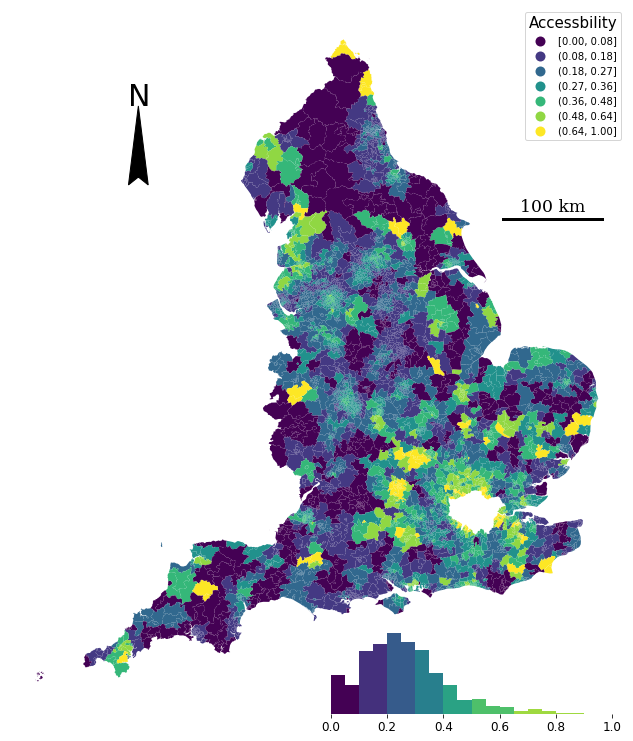

In [16]:
# 10 miles
access_break('2sfca_10_normalized')
#plt.savefig('figure/2sfca_10_exclude', dpi=600,bbox_inches='tight')

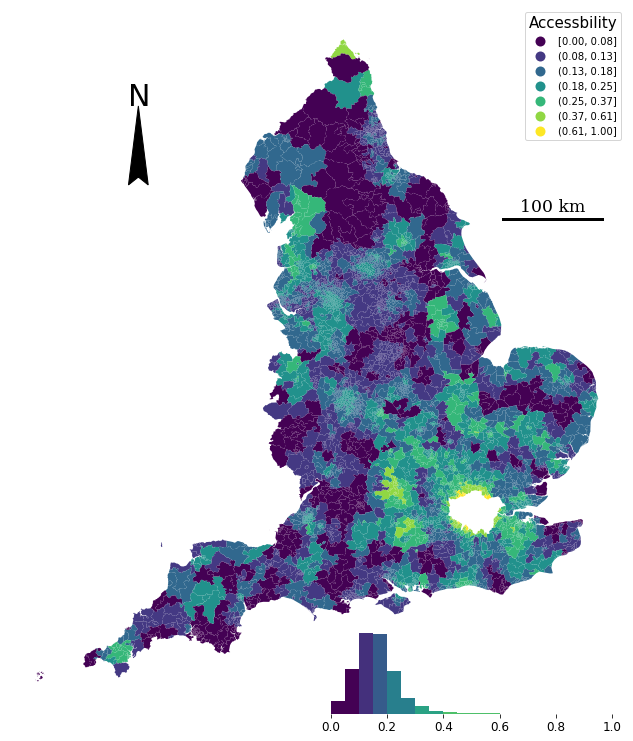

In [17]:
# 15 miles
access_break('2sfca_15_normalized')
#plt.savefig('figure/2sfca_15_exclude', dpi=600,bbox_inches='tight')

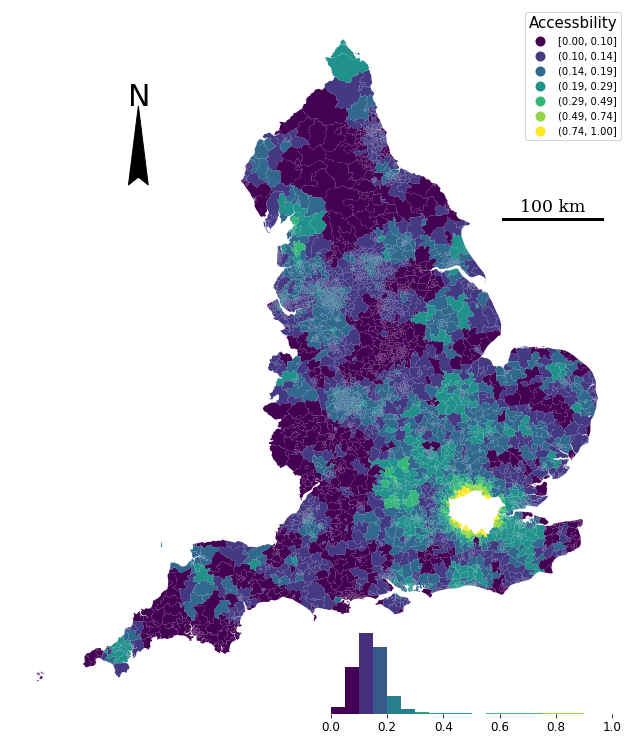

In [10]:
#20 miles
access_break('2sfca_20_normalized')
plt.savefig('figure/2sfca_20_exclude', dpi=600,bbox_inches='tight')

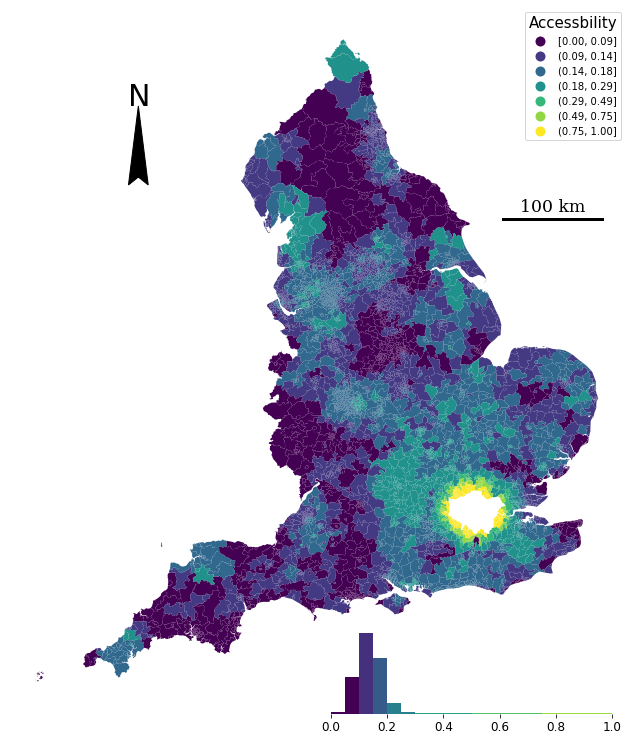

In [11]:
#25 miles
access_break('2sfca_25_normalized')
plt.savefig('figure/2sfca_25_exclude', dpi=600,bbox_inches='tight')

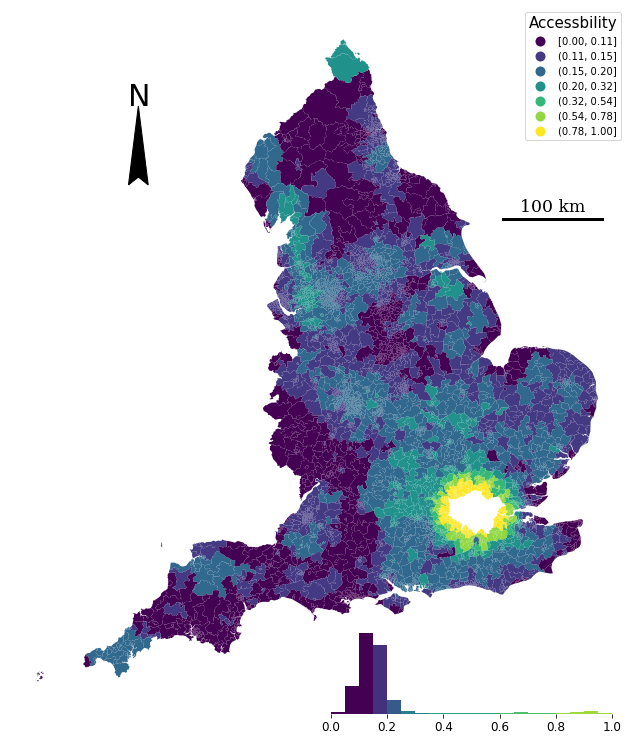

In [12]:
# 30 miles
access_break('2sfca_30_normalized')
plt.savefig('figure/2sfca_30_exclude', dpi=600,bbox_inches='tight')

### E2SFCA

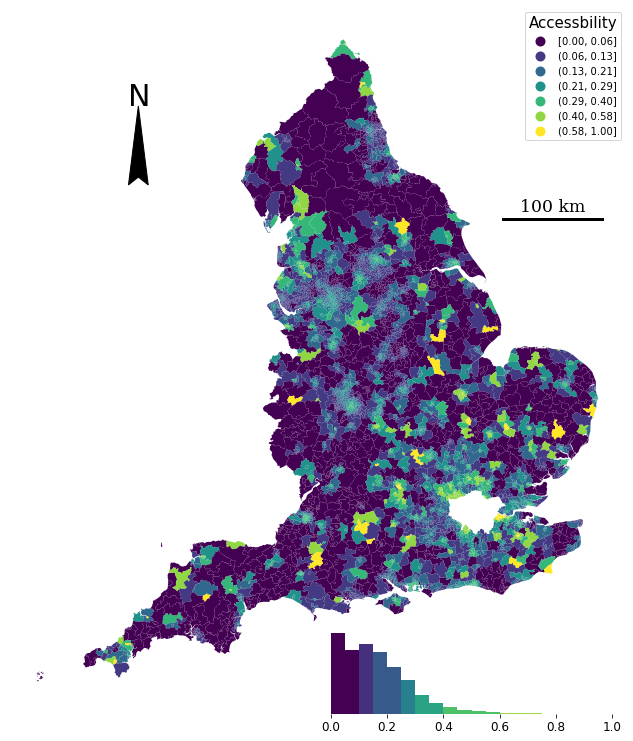

In [13]:
# 10 miles
access_break('E2sfca_10_normalized')
plt.savefig('figure/E2sfca_10_exclude', dpi=600,bbox_inches='tight')

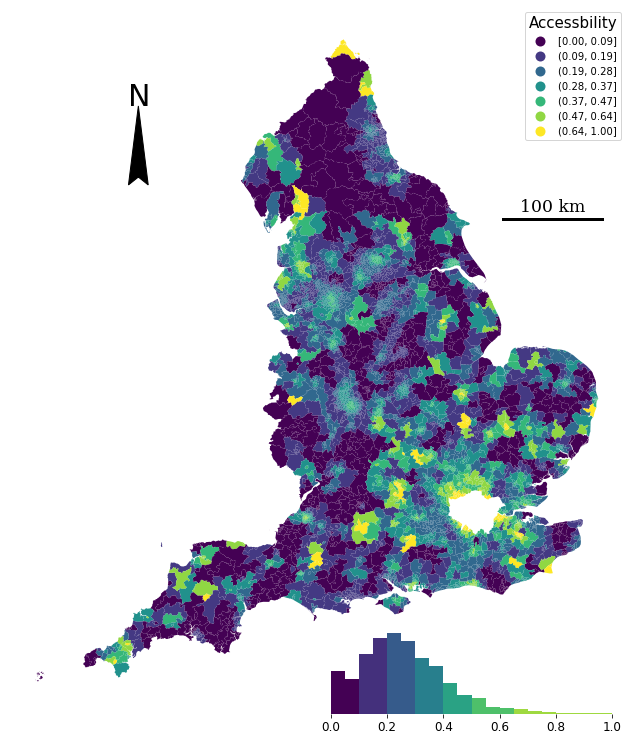

In [14]:
# 15 miles
access_break('E2sfca_15_normalized')
plt.savefig('figure/E2sfca_15_exclude', dpi=600,bbox_inches='tight')

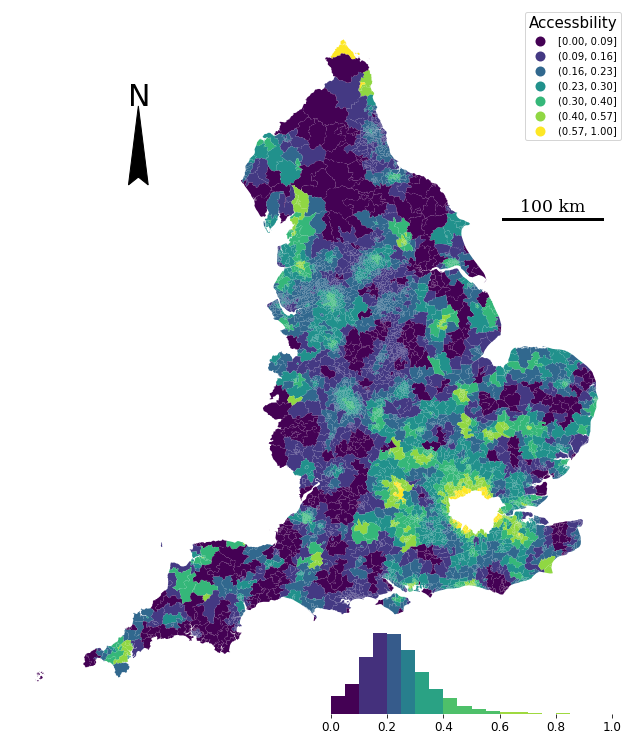

In [15]:
# 20 miles
access_break('E2sfca_20_normalized')
plt.savefig('figure/E2sfca_20_exclude', dpi=600,bbox_inches='tight')

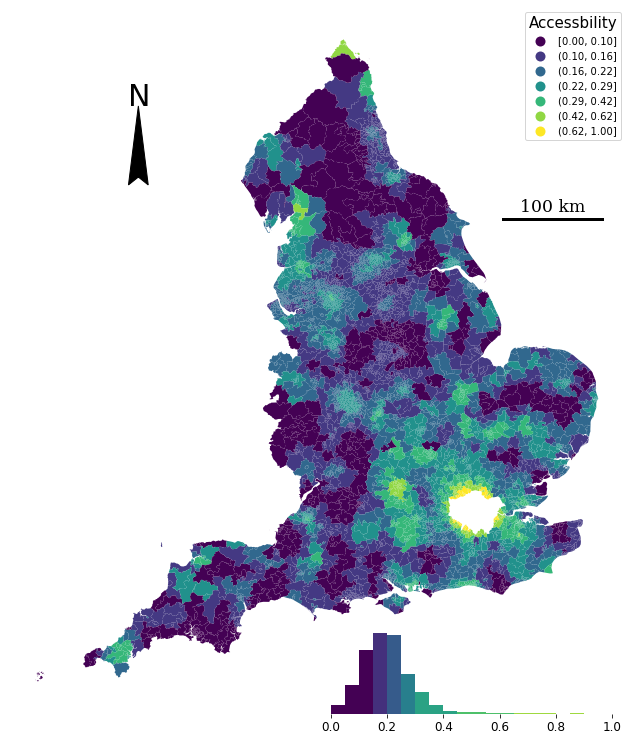

In [16]:
# 25 miles
access_break('E2sfca_25_normalized')
plt.savefig('figure/E2sfca_25_exclude', dpi=600,bbox_inches='tight')

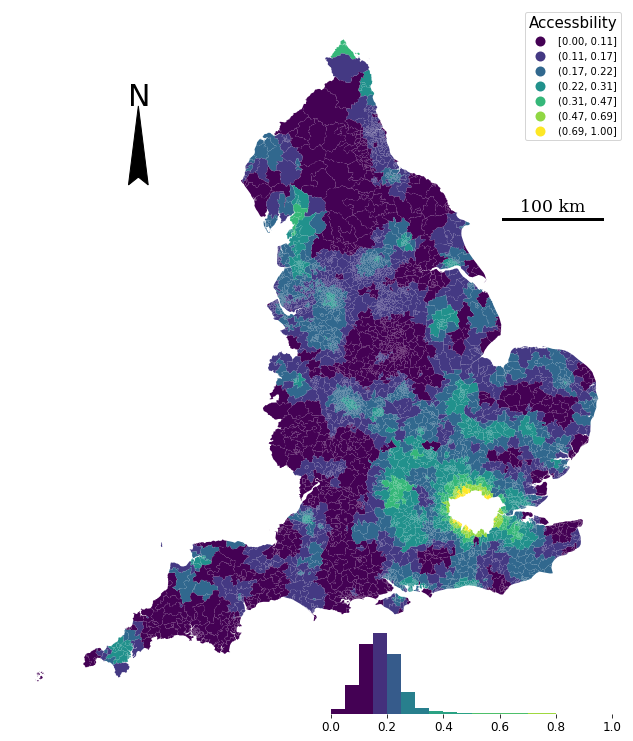

In [17]:
# 30 miles
access_break('E2sfca_30_normalized')
plt.savefig('figure/E2sfca_30_exclude', dpi=600,bbox_inches='tight')

### 3SFCA

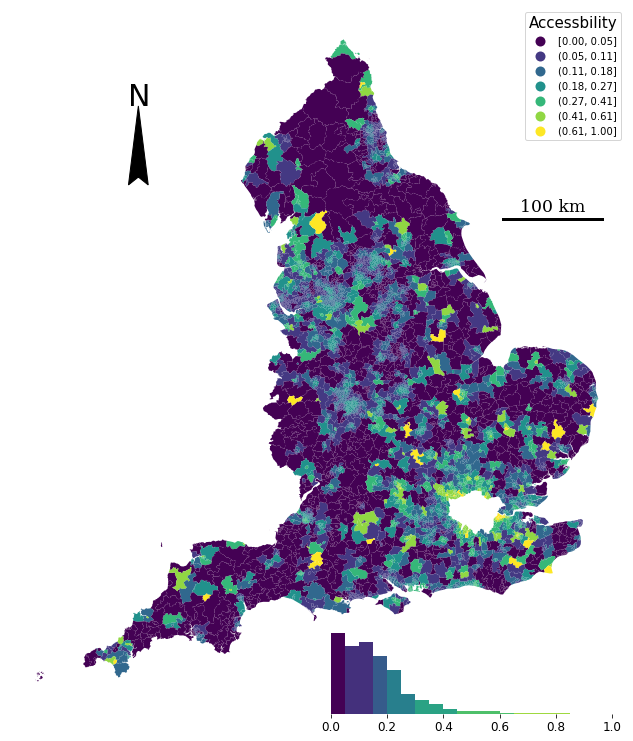

In [18]:
# 10 miles
access_break('3sfca_10_normalized')
plt.savefig('figure/3sfca_10_exclude', dpi=600,bbox_inches='tight')

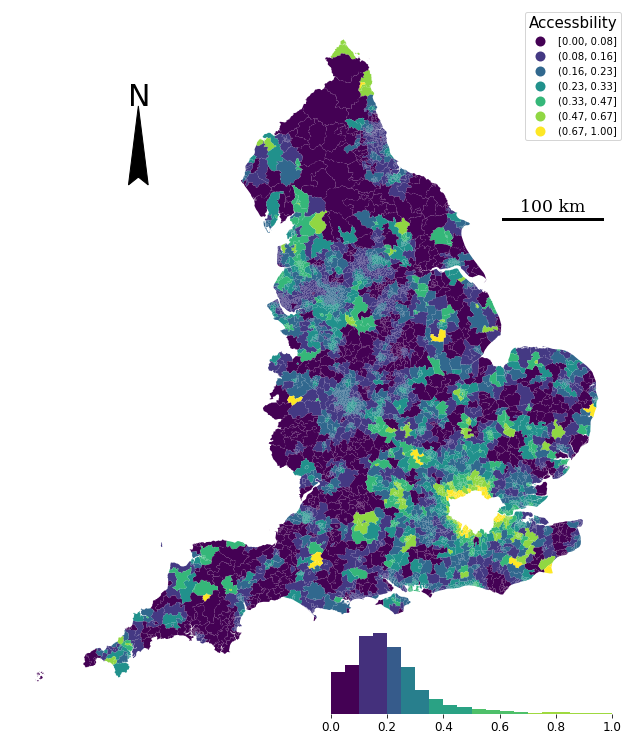

In [19]:
# 15 miles
access_break('3sfca_15_normalized')
plt.savefig('figure/3sfca_15_exclude', dpi=600,bbox_inches='tight')

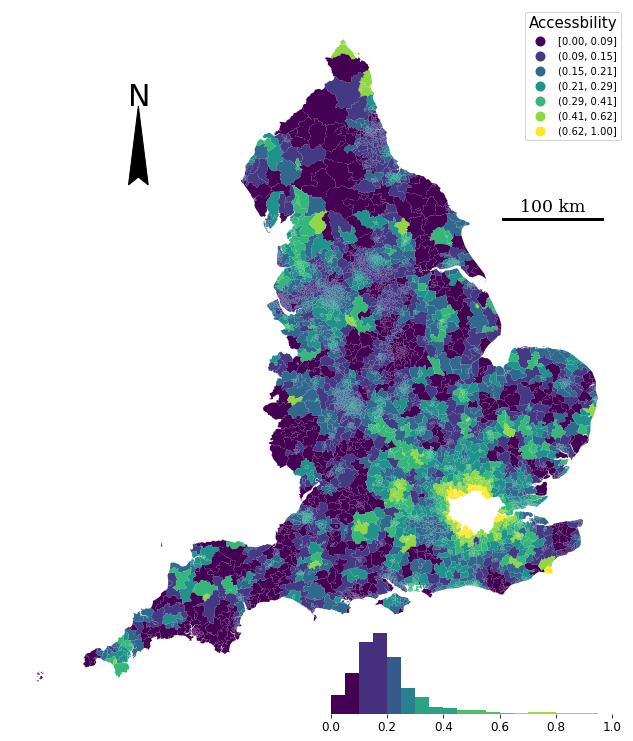

In [20]:
# 20 miles
access_break('3sfca_20_normalized')
plt.savefig('figure/3sfca_20_exclude', dpi=600,bbox_inches='tight')

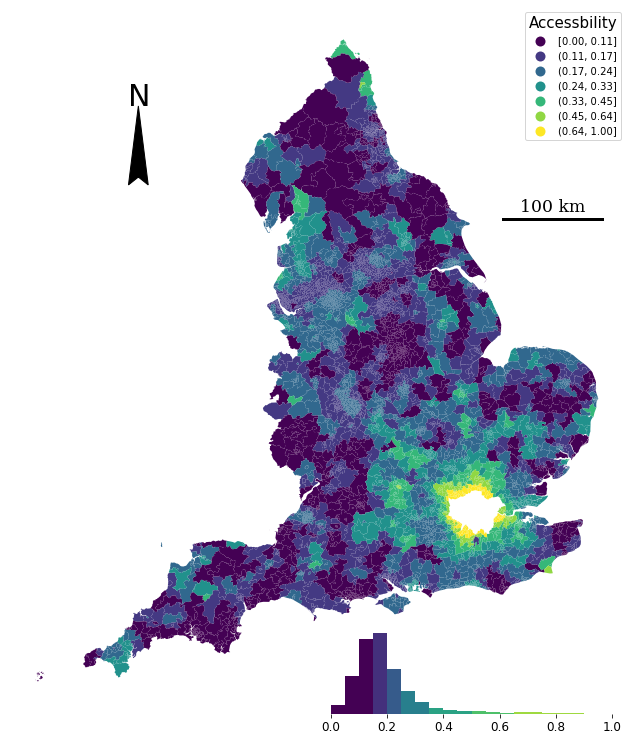

In [21]:
# 25 miles
access_break('3sfca_25_normalized')
plt.savefig('figure/3sfca_25_exclude', dpi=600,bbox_inches='tight')

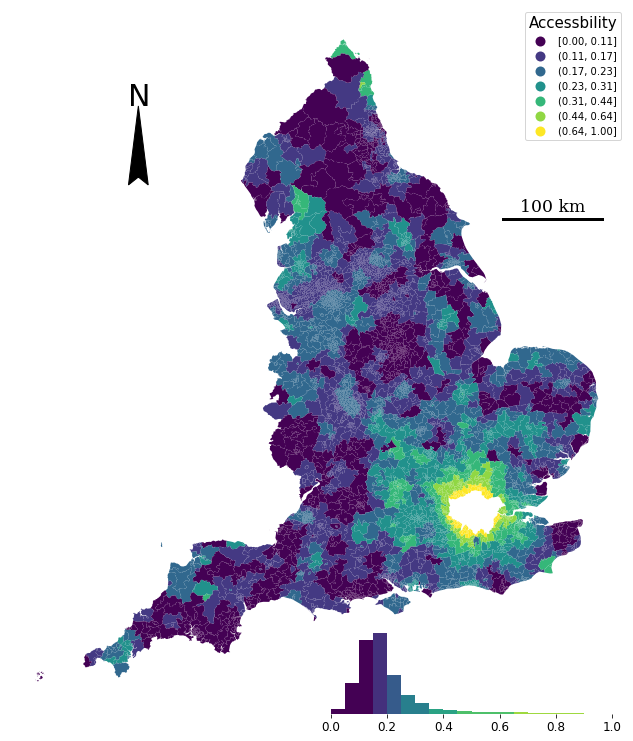

In [22]:
# 30 miles
access_break('3sfca_30_normalized')
plt.savefig('figure/3sfca_30_exclude', dpi=600,bbox_inches='tight')

## Vaccination Rate

In [23]:
# for Vaccination Rate (natural break)
def pop_rate_break(column):
    fig = plt.figure(1, figsize=(13, 13))
    ax = fig.add_subplot(111, projection=ccrs.Mercator())
    MSOA_fca.plot(ax=ax,column=column, edgecolor='None',
              scheme='NaturalBreaks',k=7,legend=True)
    ax.axis('off') 
    #ax.set_title('England Vaccination Rate in 60-69 by MSOA', fontdict={'fontsize':'20', 'fontweight':'3'})

    ax.get_legend().set_title("Vaccination Rate")
    ax.get_legend().get_title().set_fontsize('15')
    
    #north arrow
    ax.text(x=180000, y=590000, s='N', fontsize=30)
    ax.arrow(190000, 530000, 0, 60000, length_includes_head=True,
          head_width=20000, head_length=80000, overhang=.1, facecolor='k')
    #scale bar
    text_kwargs = dict(family='serif', size='xx-large')
    scale_bar(ax, (0.8, 0.7), 100,text_kwargs = text_kwargs)
    

    q = mc.NaturalBreaks(MSOA_fca[column], k=7)
    legendgram(fig, ax, 
                MSOA_fca[column], q.bins, bins=20,
                pal=palmpl.Viridis_7,
                legend_size=(0.5, 0.12), 
                loc='lower right',
                #clip=(0,100),
                frameon=False)

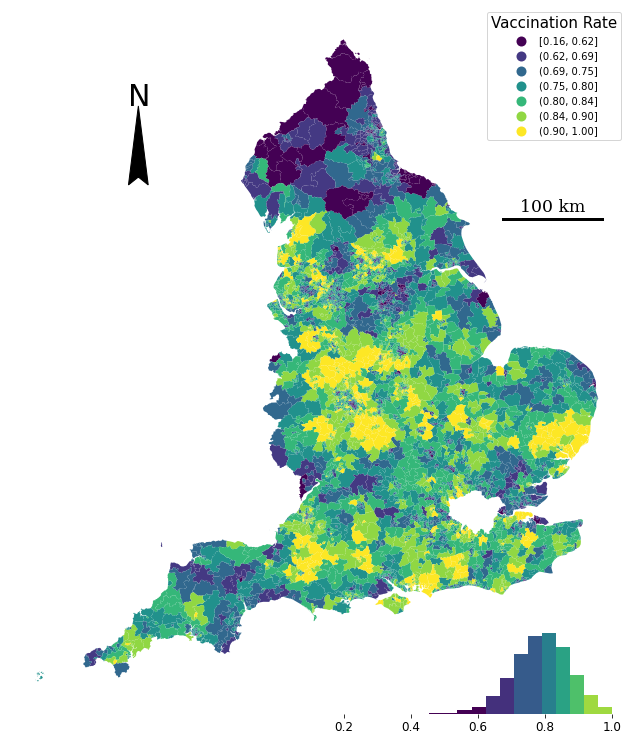

In [24]:
pop_rate_break('vaccination_rate_60+69')
plt.savefig('figure/vaccination_rate_exclude', dpi=600,bbox_inches='tight')

# Calculate Pearson and Spearman correlation coefficient of accessibility and vaccination rate

### 2SFCA
#### 10mile

In [108]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['2sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['2sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['2sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['2sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: 0.06229194506274656
p-value: 2.025373352479905e-06
Spearman correlation coefficient: 0.06328157994626363
p-value: 1.3895074740811763e-06


#### 15 mile

In [109]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['2sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['2sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['2sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['2sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: 0.07124423812609984
p-value: 5.4710800595646785e-08
Spearman correlation coefficient: 0.08638941004347289
p-value: 4.2619854805608825e-11


#### 20 mile

In [110]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['2sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['2sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['2sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['2sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: 0.06730481332237556
p-value: 2.835973860377869e-07
Spearman correlation coefficient: 0.08071056930746516
p-value: 7.288371318505467e-10


#### 25 mile

In [111]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['2sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['2sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['2sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['2sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: 0.04856387977921399
p-value: 0.00021352522823743798
Spearman correlation coefficient: 0.09230909185504552
p-value: 1.8093992691623487e-12


#### 30 mile

In [112]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['2sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['2sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['2sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['2sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: 0.03555265466689732
p-value: 0.006733402128290769
Spearman correlation coefficient: 0.0939320288608027
p-value: 7.342313013919642e-13


### E2SFCA

#### 10 mile

In [113]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['E2sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['E2sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['E2sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['E2sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: 0.01451854151026864
p-value: 0.26860464743001305
Spearman correlation coefficient: 0.0036336269801256153
p-value: 0.7818869341521084


#### 15 mile

In [114]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['E2sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['E2sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['E2sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['E2sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: 0.03475579955355265
p-value: 0.008073563218697904
Spearman correlation coefficient: 0.0324001712018526
p-value: 0.01353619820743654


#### 20 mile

In [115]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['E2sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['E2sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['E2sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['E2sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: 0.051958048830794856
p-value: 7.446207644849708e-05
Spearman correlation coefficient: 0.05448759221618205
p-value: 3.257076516264213e-05


#### 25 mile

In [116]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['E2sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['E2sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['E2sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['E2sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: 0.0619153280267224
p-value: 2.3342555134795084e-06
Spearman correlation coefficient: 0.06796451404406892
p-value: 2.166277704485104e-07


#### 30 mile

In [117]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['E2sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['E2sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['E2sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['E2sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: 0.06420844149035186
p-value: 9.714220424560712e-07
Spearman correlation coefficient: 0.07571130409807544
p-value: 7.603202003321334e-09


### 3SFCA

#### 10 mile

In [118]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['3sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['3sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['3sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['3sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: 0.04738541942819404
p-value: 0.00030325220213713424
Spearman correlation coefficient: 0.029993890130742475
p-value: 0.0222622351136548


#### 15 mile

In [119]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['3sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['3sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['3sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['3sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: 0.05696085897142823
p-value: 1.4017126138465063e-05
Spearman correlation coefficient: 0.04751579220093507
p-value: 0.00029181875778915207


#### 20 mile

In [120]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['3sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['3sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['3sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['3sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: 0.054021530538077386
p-value: 3.803298934556941e-05
Spearman correlation coefficient: 0.05646385744170915
p-value: 1.6650915501828015e-05


#### 25 mile

In [121]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['3sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['3sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['3sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['3sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: 0.04803583053822942
p-value: 0.00025010928759687794
Spearman correlation coefficient: 0.060105262629219426
p-value: 4.566127685883664e-06


#### 30 mile

In [122]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['3sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['3sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['3sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['3sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: 0.04029307463869905
p-value: 0.0021310678867192596
Spearman correlation coefficient: 0.06117225769301766
p-value: 3.0814010646511467e-06
